## Models in this notebook are Conv1D-CNN, LSTM, CNN-BLSTM, 

### Dummy trial CNN- not very useful, interrupted complex lstm structure.

In [1]:
%pip install librosa

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.1/213.1 KB 19.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 KB 16.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 323.4/323.4 KB 21.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 377.5/377.5 KB 23.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for audioread: filename=audioread-2.1.9-py3-none-any.whl size=23153 sha256=6a7fc0bba7af9514058c8c96dd62a7aba29c7ca1156fbeffba767c60813ce4f6
  Stored in directory: /root/.cache/pip/wheels/49/5a/e4/df590783499a992a88de6c0898991d1167453a3196d0d1eeb7
  Created wheel for resampy: filename=resampy-0.2.2-py3-none-any.whl size=320733 sha256=15819392044a25a46449b1db2c91d9c34e79ab6d89449e705a9847d847fd09dc
  Stored in directory: /root/.cache/pip/wheels/6f/d1/5d/f13da53b1dcbc2624ff548456c9ffb526c914f53c12c318bb4
Successfully built audioread resampy
You should consider upgrading via 

In [2]:
%pip install seaborn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 292.8/292.8 KB 18.2 MB/s eta 0:00:00
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [3]:
%pip install imbalanced-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.1/199.1 KB 18.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 17.8 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.24.0
    Uninstalling scikit-learn-0.24.0:
      Successfully uninstalled scikit-learn-0.24.0
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [41]:
import pickle

In [4]:
from os import listdir
from os.path import isfile, join
import pandas as pd
import librosa
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from timeit import default_timer as timer
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sn
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import regularizers, optimizers
from tensorflow.keras.layers import Dense, Conv1D, Flatten, Activation, MaxPooling1D, Dropout
from tensorflow.keras.utils import plot_model,to_categorical

In [5]:
class Diagnosis():
    def __init__ (self, id, diagnosis, image_path):
        self.id = id
        self.diagnosis = diagnosis 
        self.image_path = image_path   

In [6]:
def get_wav_files():
    audio_path ='audio_and_txt_files'    
    # audio_path removed in join() - NO
    files = [f for f in listdir(audio_path) if isfile(join(audio_path, f))]  #Gets all files in dir
    # print ("files:", files)
    
    
    wav_files = [f for f in files if f.endswith('.wav')]  # Gets wav files 
    wav_files = sorted(wav_files)
    
    # print ("wav_files:", wav_files)
    
    
    return wav_files, audio_path

In [7]:
# get_wav_files()

In [8]:
def diagnosis_data():
    diagnosis = pd.read_csv('patient_diagnosis.csv')
    # print ("diagnosis", diagnosis) 
  
    wav_files, audio_path = get_wav_files()
    # print ("audio_path", audio_path)
    
    diag_dict = { 101 : "URTI"}  
    diagnosis_list = []
  
    for index , row in diagnosis.iterrows():
        diag_dict[row[0]] = row[1]     

    c = 0
    
    # here 
    audio_path_new = "audio_and_txt_files/"
    
    for f in wav_files:
        
        # issue here: 
        # print ("audio_path_new+f:", audio_path_new+f)
        diagnosis_list.append(Diagnosis(c, diag_dict[int(f[:3])], audio_path_new+f)) # audio_path+f   
        c+=1  
        
    # print("diagnosis_list", diagnosis_list)

#     return diagnosis_list[0:10]
    return diagnosis_list

In [9]:
# diagnosis_data()

In [10]:
def audio_features(filename): 
    sound, sample_rate = librosa.load(filename)
    stft = np.abs(librosa.stft(sound))  
 
    mfccs = np.mean(librosa.feature.mfcc(y=sound, sr=sample_rate, n_mfcc=40),axis=1)
    chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate),axis=1)
    mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)
    contrast = np.mean(librosa.feature.spectral_contrast(S=stft, sr=sample_rate),axis=1)
    tonnetz = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(sound), sr=sample_rate),axis=1)
    
    concat = np.concatenate((mfccs,chroma,mel,contrast,tonnetz))
    return concat


In [11]:
# audio_features('219_2b2_Tc_mc_LittC2SE.wav')

In [12]:
def data_points():
    labels = []
    images = []

    to_hot_one = {"COPD":0, "Healthy":1, "URTI":2, "Bronchiectasis":3, "Pneumonia":4, "Bronchiolitis":5, "Asthma":6, "LRTI":7}

    count = 0
    for f in diagnosis_data():
        print(count)
        labels.append(to_hot_one[f.diagnosis]) 
        images.append(audio_features(f.image_path))
        count+=1

    return np.array(labels), np.array(images)

In [13]:
# data_points()

In [14]:
########################################################################################################################################
########################################################################################################################################
########################################################################################################################################

In [15]:
# SMOTE Related Techniques 

In [16]:
# images

In [17]:
# labels

In [18]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import Pipeline

In [19]:
# from collections import Counter

# # summarize the new class distribution
# counter = Counter(labels)
# print(counter)

#### Method 1: SMOTE - OVERSAMPLING
    # source: https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/

In [20]:
# from imblearn.over_sampling import SMOTE

In [21]:
# # transform the dataset --> errors out 
# oversample = SMOTE()
# images, labels = oversample.fit_resample(images, labels)

# # ValueError: Expected n_neighbors <= n_samples,  but n_samples = 1, n_neighbors = 6

#### Method 2: Force ALL Classes to be Equally Occurring  
    # class imbalance for multiple classes 
        # source: https://imbalanced-learn.org/stable/auto_examples/api/plot_sampling_strategy_usage.html

In [22]:
# sampling_strategy = "not minority"

# rus = RandomUnderSampler(sampling_strategy=sampling_strategy)
# images_2, labels_2 = rus.fit_resample(images, labels)

In [23]:
# images_2

In [24]:
# labels_2

In [25]:
# # summarize class distribution
# counter = Counter(labels_2)
# print(counter)

In [26]:
# do same thing as above with 'not majority' 

In [27]:
# sampling_strategy = "not majority"

# ros = RandomOverSampler(sampling_strategy=sampling_strategy)
# images_2, labels_2 = ros.fit_resample(images, labels)

In [28]:
# # summarize class distribution
# counter = Counter(labels_2)
# print(counter)

#### Method 3: Custom Random Sampling w/Dictionary
    # source: https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/

In [29]:
# # {"COPD":0, "Healthy":1, "URTI":2, "Bronchiectasis":3, "Pneumonia":4, "Bronchiolitis":5, "Asthma":6, "LRTI":7}
# sampling_strategy = {0: 39, 1: 26, 2: 19, 3: 15, 4: 13, 5: 13, 6:1, 7:2} #customize

# ros = RandomOverSampler(sampling_strategy=sampling_strategy)
# images, labels = ros.fit_resample(images, labels)

#### Method 4: Oversample Minority Classes Then Undersample Majority Class 
    # source: https://machinelearningmastery.com/random-oversampling-and-undersampling-for-imbalanced-classification/

In [30]:
# NOTE: only works for binary classification!

# over = RandomOverSampler(sampling_strategy=0.1)
# images, labels = over.fit_resample(images, labels)

# under = RandomUnderSampler(sampling_strategy=0.5)
# images, labels = under.fit_resample(images, labels)

In [31]:
########################################################################################################################################
########################################################################################################################################
########################################################################################################################################

In [32]:
def preprocessing(labels, images):  
    

  # Remove Asthma and LRTI
    images = np.delete(images, np.where((labels == 7) | (labels == 6))[0], axis=0) 
    labels = np.delete(labels, np.where((labels == 7) | (labels == 6))[0], axis=0)  
    
    print ("labels_original:", labels) 
    print ("\n")
    
    # Custom Method Using Dict -- Undersample then Oversample for Multi-class Problem 
    
    # step 1: oversample minority classes 
        # original: {"COPD":0, "Healthy":1, "URTI":2, "Bronchiectasis":3, "Pneumonia":4, "Bronchiolitis":5, "Asthma":6, "LRTI":7}
    
    sampling_strategy_over = {1: 118, 2: 82, 3: 73, 4: 118, 5: 63} #customize dataset here 
    over = RandomOverSampler(sampling_strategy=sampling_strategy_over)
    images, labels = over.fit_resample(images, labels)
    
    # step 2: undersample majority class COPD 
    
    sampling_strategy_under = {0: 393} #customize dataset here 
    under = RandomUnderSampler(sampling_strategy=sampling_strategy_under)
    images, labels = under.fit_resample(images, labels)
    
    print ("labels_resampled:", labels) 
    print ("\n")

  # Split data
    # stratify: https://stackoverflow.com/questions/34842405/parameter-stratify-from-method-train-test-split-scikit-learn
    X_train, X_test, y_train, y_test = train_test_split(images, labels, stratify=labels, test_size=0.2, random_state=10)

  # Hot one encode the labels
    y_train = to_categorical(y_train)
    y_test = to_categorical(y_test)  

  # Format new data
    y_train = np.reshape(y_train, (y_train.shape[0], 6))
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
    y_test = np.reshape(y_test, (y_test.shape[0], 6))
    X_test = np.reshape(X_test, (X_test.shape[0], X_train.shape[1],  1))

    return X_train, X_test, y_train, y_test

In [33]:
from timeit import Timer

start = Timer()

labels, images = data_points()

# print ("labels", labels)
 
X_train, X_test, y_train, y_test = preprocessing(labels, images)

# print('Time taken: ', (Timer() - start))

0


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[0.06973912 0.10266001 0.09116188 ... 0.08305359 0.08018959 0.08612607] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)
/usr/local/lib/python3.8/dist-packages/librosa/util/decorators.py:88: UserWarning: Trying to estimate tuning from empty frequency set.
  return f(*args, **kwargs)


1


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[-0.02710837 -0.03993464 -0.03530752 ... -0.04230435 -0.04145976
 -0.04527003] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)
/usr/local/lib/python3.8/dist-packages/librosa/util/decorators.py:88: UserWarning: Trying to estimate tuning from empty frequency set.
  return f(*args, **kwargs)


2


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.00283427  0.00423394  0.0036414  ... -0.01369482 -0.01395124
 -0.01601286] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


3


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[-0.2545646  -0.3705388  -0.3232833  ... -0.05145296 -0.04831332
 -0.05130891] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


4


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 3.1871754e-05  6.1540527e-06 -3.7155998e-05 ... -1.4125325e-02
 -8.7606525e-03  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


5


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.00079253  0.00089992  0.00091092 ... -0.0049351  -0.00259066
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


6


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 3.0208554e-05  3.0756044e-05  2.5381032e-05 ... -1.8259089e-02
 -1.1751885e-02 -5.7575861e-03] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


7


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[-0.00064508 -0.00077814 -0.0008623  ... -0.01482992 -0.00782498
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


8


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.00110417  0.00130484  0.00140896 ... -0.01235658 -0.00798214
 -0.00392708] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


9


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 4.3292630e-07  3.4875336e-06  7.9502988e-06 ... -4.9829770e-02
 -2.8054921e-02  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


10


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[0.00072088 0.00177286 0.00336674 ... 0.03278232 0.03167795 0.0341762 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


11


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[-0.00510358 -0.00659909 -0.00531301 ...  0.05819363  0.05827237
  0.06406491] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


12


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.13885312  0.2046399   0.18167366 ... -0.07205222 -0.07236856
 -0.08180486] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


13


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.03220347 -0.02862145
 -0.02812669] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


14


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[0.         0.         0.         ... 0.81411314 0.78380513 0.8405024 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


15


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[0.         0.         0.         ... 0.28938666 0.28141105 0.30212826] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


16


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.15555128 -0.14919281
 -0.1552921 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


17


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[0.         0.         0.         ... 0.02469628 0.02214978 0.01944208] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


18


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.34570014 -0.3405181
 -0.3718672 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


19


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.36524588 -0.35146987
 -0.37641573] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


20


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[0.         0.         0.         ... 0.2956407  0.29205394 0.32385424] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


21


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.87327844 -0.8426849
 -0.904111  ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


22


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[0.         0.         0.         ... 0.0803633  0.0761212  0.08159862] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


23


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[0.         0.         0.         ... 0.07362223 0.07534675 0.08184994] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


24


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.05340556 -0.05322314
 -0.06046366] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


25


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[0.         0.         0.         ... 0.0193855  0.01567397 0.01235512] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


26


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[0.         0.         0.         ... 0.21379106 0.19591363 0.19900955] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


27


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.03690046 -0.04028837
 -0.03777801] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


28


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.00110044  0.00122915
 -0.00134384] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


29


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.27841818 -0.26466727
 -0.28203356] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


30


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.2630472  -0.25217113
 -0.26920825] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


31


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[0.         0.         0.         ... 0.17355038 0.17127629 0.1912121 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


32


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.21676135 -0.20801996
 -0.22263572] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


33


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.05899765 -0.06244634
 -0.06870328] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


34


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[0.         0.         0.         ... 0.70110035 0.68612456 0.7446984 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


35


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.10050876 -0.09557786
 -0.09832459] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


36


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.09969431 -0.10169579
 -0.11254872] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


37


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.09392171 -0.09050354
 -0.09884936] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


38


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.10735268 -0.10226697
 -0.10870948] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


39


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.36982933 -0.3683851
 -0.4094502 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


40


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[-0.00949192 -0.01515338 -0.01494973 ...  0.03122446  0.03000467
  0.03189378] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)
/usr/local/lib/python3.8/dist-packages/librosa/util/decorators.py:88: UserWarning: Trying to estimate tuning from empty frequency set.
  return f(*args, **kwargs)


41


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[-1.7585522e-06 -2.2429733e-06 -1.9274846e-06 ... -1.1987473e-02
 -7.4312286e-03  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


42


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[-3.1364743e-05 -3.4258581e-05 -3.3931665e-05 ...  5.3538714e-04
  3.7836187e-04  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


43


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[-2.9586021e-05 -3.3629472e-05 -3.4923316e-05 ... -2.4650006e-03
 -1.3031738e-03  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


44


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[3.0384650e-05 3.1305051e-05 2.8012693e-05 ... 3.9614424e-02 2.4514157e-02
 0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


45


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[-0.00015414 -0.00019182 -0.00021949 ...  0.02211454  0.01247506
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


46


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[2.9788309e-05 3.2301657e-05 3.1995405e-05 ... 1.5126610e-03 9.7192550e-04
 4.7570144e-04] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


47


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[-0.30551556 -0.337594   -0.35426965 ...  0.04488467  0.02582479
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


48


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[-0.30030748 -0.3313869  -0.3471481  ... -0.10257331 -0.06606323
 -0.03239066] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


49


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[-0.5566892  -0.61342674 -0.6413218  ... -0.07702224 -0.0493612
 -0.02408693] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


50


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[-0.87746686 -0.9691256  -1.0164407  ... -0.2245433  -0.14452285
 -0.07082193] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


51


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[-0.14500825 -0.16018207 -0.16798463 ...  0.11473081  0.06627245
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


52


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[-0.00199708 -0.00319508 -0.00331803 ... -0.00064225 -0.00038474
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


53


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[-0.00066345 -0.00110385 -0.00104151 ...  0.00647592  0.00655071
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


54


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[-0.2739319  -0.3025994  -0.31744638 ...  0.01044763  0.00608007
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


55


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[-0.06291798 -0.07026124 -0.07465484 ... -0.14951584 -0.09621288
 -0.04716552] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


56


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[-1.7918481e-06 -5.5685846e-06 -9.9844920e-06 ...  2.7333383e-02
  1.7636651e-02  8.6638099e-03] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


57


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 8.5524260e-07 -2.3861974e-06 -7.3340552e-06 ... -1.3542055e-01
 -8.7212533e-02 -4.2756353e-02] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


58


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[-0.00027686 -0.00032779 -0.00035314 ... -0.03754111 -0.02402511
 -0.01169831] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


59


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[-1.7565626e-06 -1.2353955e-06  5.4582960e-09 ... -2.6573552e-02
 -1.6467988e-02  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


60


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[0.000215   0.00023683 0.00023057 ... 0.0034874  0.00196025 0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


61


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[-3.0497395e-07  1.2244502e-06  3.1903026e-06 ... -9.8866746e-03
 -5.5146376e-03  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


62


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[6.2300285e-05 7.5929711e-05 8.4309846e-05 ... 9.5062396e-03 5.8767227e-03
 0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


63


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[2.0636191e-06 5.3742210e-06 7.9173615e-06 ... 8.8258702e-03 5.2438602e-03
 0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


64


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[-1.5476845e-06 -1.4929913e-06  7.7756016e-07 ...  1.0041645e-03
  6.2980881e-04  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


65


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.1246614  -0.1273088
 -0.14728566] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


66


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.02250578 -0.02148935
 -0.02268108] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


67


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.01565223 -0.01456963
 -0.01511466] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


68


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[0.         0.         0.         ... 0.06823757 0.06161449 0.0576618 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


69


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.05935252 -0.06028523
 -0.06810508] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


70


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.15286843  0.22476168  0.19892806 ... -0.0103288  -0.01059507
 -0.01229341] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


71


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[0.01386719 0.02011131 0.01776993 ... 0.00524451 0.00579907 0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


72


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[-0.00679656 -0.01003796 -0.00873371 ... -0.02517475 -0.03054456
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


73


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.00581356  0.00853608  0.00752986 ... -0.00082151 -0.00067481
 -0.00068022] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


74


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[-0.00052752 -0.00080186 -0.00074426 ... -0.00522504 -0.00524094
 -0.00583472] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


75


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[-2.8764509e-05 -3.0061437e-05 -2.9183469e-05 ... -1.0795601e-03
 -5.5044401e-04  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


76


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[-7.8413684e-08  9.5552173e-07  1.9807621e-06 ... -3.6296784e-03
 -2.0876050e-03  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


77


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[1.8421345e-06 3.9703418e-06 4.0728492e-06 ... 1.1935446e-03 6.8373588e-04
 0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


78


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[-2.2084580e-06 -5.9585232e-06 -8.7529661e-06 ... -3.4101740e-02
 -2.1929748e-02 -1.0731890e-02] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


79


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[-5.8840362e-07  2.2181875e-06  5.4235775e-06 ...  3.1400897e-02
  1.6541665e-02  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


80


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 5.9769508e-07  8.8926954e-06  2.1092692e-05 ... -1.6348783e-02
 -8.8511044e-03  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


81


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.00772112  0.01154974  0.01025985 ... -0.00331286 -0.00319674
 -0.00373467] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


82


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[0.28596535 0.3158219  0.33115914 ... 0.08994886 0.05179574 0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


83


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[-0.27563092 -0.30399603 -0.31818    ...  0.00215952  0.00126481
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


84


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[0.03946353 0.04340422 0.04541007 ... 0.4538223  0.29210246 0.14312147] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


85


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[-0.3726952  -0.41175988 -0.43205068 ... -0.15957749 -0.10276388
 -0.05036703] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


86


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[-0.2810858  -0.31157294 -0.32829928 ... -0.1266794  -0.08168591
 -0.04014152] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


87


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[-0.07494402 -0.10856441 -0.09363505 ...  0.01878147  0.01818044
  0.01986458] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


88


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.03124345  0.04578807  0.04021889 ... -0.01389685 -0.01351096
 -0.01445526] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


89


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[-0.02912062 -0.04265247 -0.0383432  ... -0.07223672 -0.07001921
 -0.07563277] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


90


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.00184422  0.00249039  0.00193569 ... -0.00437545 -0.00411891
 -0.0043499 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


91


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[-0.06444195 -0.09441856 -0.08402737 ... -0.0168679  -0.01541069
 -0.01584203] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


92


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[0.0641613  0.09456229 0.08389656 ... 0.24824695 0.24024625 0.25876576] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


93


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.08261342  0.12128571  0.10703805 ... -0.0236706  -0.02263591
 -0.02428091] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


94


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[-0.00484761 -0.00677189 -0.00544328 ...  0.01484069  0.01375641
  0.01390095] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


95


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[0.13323656 0.1947597  0.1715939  ... 0.0848894  0.08218376 0.08881931] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


96


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[0.02924083 0.04405269 0.04040422 ... 0.0765257  0.07466643 0.08053859] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


97


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.03005545  0.04300415  0.0366232  ... -0.01147958 -0.01104868
 -0.01202016] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


98


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[6.0555729e-05 7.3114075e-05 8.1377519e-05 ... 8.7227272e-03 4.8832153e-03
 0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


99


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 1.3562662e-06  9.4506561e-07 -8.5865324e-09 ...  3.3021986e-02
  1.8553611e-02  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


100


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[6.1053885e-05 7.3011215e-05 8.0253209e-05 ... 5.3349137e-03 2.8286560e-03
 0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


101


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 6.7988680e-07 -5.5855821e-06 -1.5208361e-05 ...  1.3006850e-02
  6.8495930e-03  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


102


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[-8.7546437e-07 -1.6883479e-06 -2.0232412e-06 ...  8.1363264e-03
  4.2472398e-03  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


103


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[-2.2965232e-06  1.4332079e-05  3.7568196e-05 ... -5.9282253e-03
 -3.7157908e-03  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


104


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[-0.05889968 -0.0843979  -0.07164755 ... -0.03685335 -0.03530435
 -0.03779947] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


105


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[-0.00703415 -0.01040321 -0.0091257  ...  0.08334509  0.08262308
  0.08995433] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


106


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[0.00841071 0.0121377  0.01047836 ... 0.01875647 0.01999779 0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


107


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[-0.0016762  -0.00256096 -0.00230716 ...  0.00077861  0.00061742
  0.00064241] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


108


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.00833424  0.01223366  0.01093073 ... -0.02901716 -0.02817098
 -0.03024276] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


109


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.09029481 -0.0873507
 -0.09304363] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


110


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[0.         0.         0.         ... 0.00045609 0.0003019  0.00025992] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


111


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[0.         0.         0.         ... 0.25430447 0.24422939 0.26596078] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


112


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.18819222 -0.18661733
 -0.20472558] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


113


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[0.         0.         0.         ... 0.63284063 0.60743934 0.6499954 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


114


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.15598866 -0.14904915
 -0.15697648] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


115


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.14993559 -0.14534871
 -0.15865172] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


116


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.03817068 -0.03789793
 -0.04186339] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


117


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.06267441 -0.06021754
 -0.06459808] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


118


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.28729856 -0.27888495
 -0.3043572 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


119


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.12467271 -0.11600577
 -0.12349898] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


120


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.31176618 -0.30284992
 -0.32902914] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


121


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.60127103 -0.58667856
 -0.63932043] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


122


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.0946022  -0.09184402
 -0.10031813] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


123


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[0.         0.         0.         ... 0.06827468 0.06824982 0.07497446] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


124


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.02097249 -0.01937039
 -0.01917268] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


125


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[0.         0.         0.         ... 0.05705289 0.0558563  0.0643323 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


126


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[0.         0.         0.         ... 0.10999833 0.11247327 0.13822523] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


127


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.27760413 -0.26543257
 -0.28145796] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


128


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[0.         0.         0.         ... 0.65127534 0.62605536 0.6707199 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


129


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.00709364  0.01156462
  0.03049873] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


130


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.04219826 -0.04254581
 -0.0484707 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


131


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.01045139 -0.00813207
 -0.00583766] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


132


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[0.         0.         0.         ... 0.06660642 0.06494996 0.07326572] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


133


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.09694475 -0.09403306
 -0.10090378] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


134


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[0.         0.         0.         ... 0.04832041 0.04317094 0.04476513] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


135


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[0.         0.         0.         ... 0.12839644 0.12456677 0.13299009] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


136


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.10613709 -0.10303612
 -0.11077289] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


137


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.04282593 -0.04238395
 -0.04544039] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


138


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[0.         0.         0.         ... 0.083089   0.08195258 0.09005941] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


139


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[0.         0.         0.         ... 0.05441999 0.05423787 0.06180205] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


140


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.14651377 -0.14105655
 -0.14906457] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


141


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.27125984 -0.26021016
 -0.2764414 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


142


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[0.         0.         0.         ... 0.0585973  0.05836105 0.06448523] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


143


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[0.         0.         0.         ... 0.09016424 0.08735418 0.09367996] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


144


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[0.         0.         0.         ... 0.14888787 0.14211847 0.1541706 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


145


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.01632545 -0.01282723
 -0.00885917] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


146


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[0.         0.         0.         ... 0.03141705 0.02939386 0.03129841] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


147


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[0.         0.         0.         ... 0.06878198 0.06660396 0.07093561] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


148


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[0.         0.         0.         ... 0.04316495 0.04267831 0.04639468] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


149


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[0.         0.         0.         ... 0.13848418 0.13754933 0.15602513] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


150


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.         0.         0.        ... -1.0097102 -0.9775502 -1.0539925] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


151


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.85299814 -0.82649523
 -0.8955253 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


152


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[0.         0.         0.         ... 0.7048156  0.6856423  0.73900527] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


153


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.05970628 -0.05912326
 -0.06879056] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


154


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.04253686 -0.03156869
 -0.03439959] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


155


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.1210754  -0.11012995
 -0.12194332] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


156


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[0.         0.         0.         ... 0.03322249 0.03475716 0.03962392] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


157


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.00966163 -0.00935669
 -0.01002169] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


158


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[0.         0.         0.         ... 0.00453875 0.00423446 0.00409788] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


159


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[0.         0.         0.         ... 0.00407723 0.00422076 0.00499802] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


160


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.06537674 -0.06403388
 -0.0701403 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


161


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.06712063 -0.06457045
 -0.0705644 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


162


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.0976614  -0.09129208
 -0.10092844] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


163


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.24244906 -0.23363335
 -0.25135463] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


164


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.07715066 -0.07355026
 -0.0813847 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


165


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.12481783 -0.11626637
 -0.12245337] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


166


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.01072771 -0.0103346
 -0.0112439 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


167


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[0.         0.         0.         ... 0.24656756 0.23585147 0.24984139] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


168


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[0.         0.         0.         ... 0.12078524 0.11941598 0.12979318] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


169


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[0.         0.         0.         ... 0.00542939 0.00536905 0.00364072] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


170


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[0.         0.         0.         ... 0.00592054 0.00539975 0.00579786] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


171


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.15077144 -0.14892101
 -0.17195728] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


172


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[0.         0.         0.         ... 0.04400342 0.04112874 0.04556485] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


173


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.0303906  -0.03023243
 -0.03382241] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


174


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 5.2000833e-05 1.1785072e-04
 4.3571499e-04] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


175


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[0.08209334 0.12027321 0.10592982 ... 0.09523189 0.09189781 0.09868933] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


176


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.00026478  0.00029944  0.00015457 ... -0.00348308 -0.0033619
 -0.00359   ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


177


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[-0.01996863 -0.02962243 -0.02663773 ... -0.02847892 -0.02834579
 -0.0315886 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


178


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.53911144 -0.52192086
 -0.5663301 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


179


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[0.         0.         0.         ... 0.03784459 0.03614867 0.03944295] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


180


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[0.         0.         0.         ... 0.04260475 0.04491537 0.05590165] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


181


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[0.         0.         0.         ... 0.05403832 0.05288235 0.05756818] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


182


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[0.         0.         0.         ... 0.09214053 0.09400132 0.1008988 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


183


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[0.         0.         0.         ... 0.11687199 0.11118703 0.11946625] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


184


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[0.         0.         0.         ... 0.47922876 0.4552795  0.4909352 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


185


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.01119357 -0.00802472
 -0.01137619] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


186


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.05364073 -0.05210173
 -0.05582038] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


187


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[0.         0.         0.         ... 0.88000935 0.84383327 0.9057278 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


188


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[0.         0.         0.         ... 0.22387065 0.21817988 0.23660232] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


189


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[0.         0.         0.         ... 0.9459728  0.91875696 0.9850744 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


190


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.0310529  -0.02861737
 -0.03650299] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


191


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.0900756  -0.09057484
 -0.10140962] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


192


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.9539692  -0.92492354
 -0.98152196] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


193


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.15018542 -0.14646009
 -0.15747313] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


194


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.1251332  -0.12137617
 -0.12776214] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


195


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.0088842  -0.00718911
 -0.00901421] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


196


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[0.         0.         0.         ... 0.08541998 0.08474052 0.0946577 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


197


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[0.0451534  0.06603235 0.05780839 ... 0.02463541 0.02397312 0.02568223] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


198


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.01947807  0.02848387  0.02508411 ... -0.03352774 -0.03243613
 -0.03466624] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


199


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[0.1217619  0.17827111 0.15659006 ... 0.1134396  0.11024933 0.1200155 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


200


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[0.00632992 0.00817893 0.00611793 ... 0.09045102 0.0881533  0.09588311] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


201


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[-0.15628257 -0.22893853 -0.20166497 ... -0.03171033 -0.03224102
 -0.03648872] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


202


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[0.18540692 0.27133536 0.2384167  ... 0.04378628 0.04378669 0.04921889] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


203


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[0.18108626 0.26463994 0.232366   ... 0.32035995 0.30918318 0.33237106] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


204


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[-0.02086514 -0.03026704 -0.02662488 ...  0.04137098  0.03996061
  0.04264543] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


205


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.03595259  0.0499021   0.04025383 ... -0.24192247 -0.23513441
 -0.25428212] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


206


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.06173367  0.09047343  0.07957916 ... -0.1636507  -0.15867187
 -0.17137374] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


207


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[-0.03135543 -0.04577302 -0.04024562 ...  0.04831194  0.04670987
  0.05013475] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


208


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[-0.01031841 -0.01451374 -0.01168245 ...  0.06988565  0.06844038
  0.07430818] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


209


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.07067639  0.10370863  0.09164976 ... -0.04613643 -0.04417678
 -0.04657067] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


210


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[-0.03396667 -0.04994343 -0.0439571  ...  0.03618184  0.03445148
  0.03607936] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


211


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[0.00049533 0.00074513 0.00076639 ... 0.04596029 0.04402992 0.04716672] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


212


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.2248943   0.3293371   0.28999072 ... -0.05832735 -0.05616358
 -0.06025564] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


213


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[-0.07711207 -0.11299724 -0.09988052 ...  0.04327407  0.04188297
  0.04562894] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


214


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[-0.0354905  -0.05269967 -0.04721361 ... -0.13843046 -0.13402449
 -0.14437066] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


215


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[0.02330435 0.03429922 0.03047918 ... 0.02959513 0.02840756 0.03028148] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


216


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[-0.04389527 -0.06491797 -0.0578773  ...  0.15056932  0.14504048
  0.15519336] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


217


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[0.         0.         0.         ... 0.06871805 0.06486322 0.07575088] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


218


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[0.         0.         0.         ... 0.06055361 0.07973463 0.08662973] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


219


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[0.         0.         0.         ... 0.1932187  0.17708069 0.18315566] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


220


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[0.         0.         0.         ... 0.08156653 0.08277629 0.08971512] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


221


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[0.         0.         0.         ... 0.38486943 0.3681868  0.39275822] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


222


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[0.         0.         0.         ... 0.10773391 0.1057634  0.10625453] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


223


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[0.         0.         0.         ... 0.04215506 0.03717901 0.03802113] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


224


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[0.         0.         0.         ... 0.15522195 0.1467928  0.15593654] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


225
226


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[0.         0.         0.         ... 0.08153588 0.07715123 0.09155083] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


227


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.39173955 -0.37109867
 -0.39912966] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


228


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[0.         0.         0.         ... 0.08052712 0.07566561 0.07923378] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


229


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.57593477 -0.55204606
 -0.59175545] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


230


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[0.         0.         0.         ... 0.4060254  0.39384705 0.42273942] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


231


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[0.         0.         0.         ... 0.61231124 0.5853217  0.64058626] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


232


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[0.         0.         0.         ... 0.26619175 0.25701225 0.26893717] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


233


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[0.         0.         0.         ... 0.1681986  0.16085726 0.17991209] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


234


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.0595673  -0.05421571
 -0.05784682] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


235


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[0.         0.         0.         ... 0.5417308  0.5261696  0.56971365] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


236


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[0.         0.         0.         ... 0.15761144 0.14830564 0.15461104] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


237


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.1055009  -0.09426636
 -0.10725943] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


238


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.15406486 -0.14363146
 -0.16801926] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


239


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[0.         0.         0.         ... 0.08216925 0.07464433 0.07744946] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


240


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.10067143 -0.09703627
 -0.10442895] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


241


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.00558934 -0.00156632
 -0.00496791] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


242


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.04705798 -0.05187929
 -0.0536809 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


243


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  8.0076090e-05
 -1.0726594e-04 -3.6454562e-04] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


244


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[6.0634571e-05 5.8885256e-05 4.5460369e-05 ... 1.8835057e-03 1.1092690e-03
 0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


245


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[-2.4712881e-06 -5.1638103e-06 -6.9168277e-06 ... -2.6756365e-04
 -3.7583763e-05  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


246


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[3.0095798e-05 3.6245452e-05 4.1038627e-05 ... 1.8093728e-02 9.8271910e-03
 0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


247


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.00052289  0.00053874  0.00046727 ... -0.01250761 -0.00773672
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


248


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[-7.9725692e-07 -5.1435914e-06 -1.1148565e-05 ...  8.1616104e-02
  5.0180554e-02  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


249


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[-8.4280538e-07 -2.8361271e-06 -4.4394942e-06 ... -2.2870742e-03
 -1.5083579e-03 -7.5765629e-04] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


250


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[0.04098994 0.06048011 0.05394521 ... 0.06759399 0.06565168 0.07103837] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


251


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[0.14635253 0.21433777 0.18913296 ... 0.06801834 0.06605873 0.07174655] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


252


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[-0.21281347 -0.3119932  -0.27518836 ...  0.09971356  0.0965366
  0.1039803 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


253


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.24945469  0.36584198  0.322385   ... -0.12258895 -0.11847793
 -0.12714651] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


254


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.00151618  0.00226498  0.00199041 ... -0.00078756 -0.00079235
 -0.00091894] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


255


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[-0.10363504 -0.15187082 -0.13408616 ... -0.00881214 -0.00848053
 -0.00916573] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


256


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[-1.3997042e-04 -1.2848475e-04  3.2451644e-05 ...  1.4652788e-03
  1.3579994e-03  1.4055549e-03] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


257


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[-0.00582682 -0.0087573  -0.00789807 ...  0.00371342  0.00362012
  0.00392179] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


258


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[0.00213414 0.0030729  0.00271004 ... 0.00176497 0.00171613 0.00163209] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


259


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[-2.1205175e-05 -9.0013646e-06 -5.7985104e-05 ... -2.6757852e-04
 -2.3373037e-04 -1.5470306e-04] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


260


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[-0.00123492 -0.0017661  -0.00153104 ...  0.00878113  0.00855047
  0.00905106] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


261


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.01019299  0.01542677  0.01427354 ... -0.00532533 -0.00527768
 -0.00563498] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


262


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[-0.00046874 -0.00066505 -0.00055341 ...  0.00067021  0.00068206
  0.00081273] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


263


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[-0.00702527 -0.01071092 -0.00976034 ...  0.00861656  0.00821532
  0.00830283] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


264


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.06949438  0.10296931  0.09133144 ... -0.10478169 -0.09335185
 -0.08779465] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


265


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[-0.00247515 -0.00338422 -0.00256338 ...  0.0046447   0.00468008
  0.00582115] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


266


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[0.         0.         0.         ... 0.05333072 0.05193296 0.05411945] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


267


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[0.         0.         0.         ... 0.02863536 0.02799761 0.02987029] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


268


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.02789018 -0.02793924
 -0.03010963] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


269


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[0.         0.         0.         ... 0.3832505  0.37275493 0.40367207] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


270


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.14911003 -0.14584064
 -0.15577243] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


271


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.11749613 -0.1147119
 -0.12501863] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


272


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.20401244 -0.18976957
 -0.20265342] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


273


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[0.         0.         0.         ... 0.0249048  0.02400689 0.02587192] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


274


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.04917265 -0.04724537
 -0.05077276] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


275


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.0224619  -0.02179432
 -0.02362555] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


276


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.00383405 -0.00354899
 -0.00436938] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


277


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.01379963 -0.01337848
 -0.01428711] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


278


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[0.         0.         0.         ... 0.00367573 0.00372507 0.00390848] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


279


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[0.         0.         0.         ... 0.05285533 0.05145336 0.05648712] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


280


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[0.         0.         0.         ... 0.05652302 0.05373443 0.05823576] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


281


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[0.         0.         0.         ... 0.04610898 0.04592878 0.05159606] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


282


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[0.         0.         0.         ... 0.00382449 0.00360128 0.00380202] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


283


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[0.         0.         0.         ... 0.01050494 0.01009672 0.01089985] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


284


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.04437422 -0.04433155
 -0.04794825] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


285


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[0.         0.         0.         ... 0.13613036 0.13892016 0.16163129] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


286


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.02619893 -0.02753548
 -0.03299935] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


287


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.14280903 -0.13465735
 -0.14187784] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


288


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[0.         0.         0.         ... 0.08935134 0.08854551 0.09727266] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


289


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[0.         0.         0.         ... 0.16737725 0.16159472 0.17510675] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


290


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.03426595 -0.03770531
 -0.04042792] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


291


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[0.         0.         0.         ... 0.0948415  0.09678883 0.11038055] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


292


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[0.         0.         0.         ... 0.16828844 0.17620602 0.18314481] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


293


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.06646982 -0.05746578
 -0.0633205 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


294


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[0.         0.         0.         ... 0.6694273  0.65765065 0.71869653] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


295


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.08036347 -0.0797803
 -0.08558688] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


296


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[0.         0.         0.         ... 0.05351587 0.05153494 0.05750447] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


297


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.14392132 -0.13664263
 -0.13794924] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


298


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.07309102 -0.07521313
 -0.08835118] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


299


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[0.         0.         0.         ... 0.16966498 0.1641785  0.17809317] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


300


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[-0.08208279 -0.12059726 -0.10694534 ... -0.01454268 -0.01493376
 -0.01669737] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


301


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[-0.12124276 -0.18053189 -0.16290031 ...  0.01872895  0.01831147
  0.02005645] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


302


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[-0.00105714 -0.00163954 -0.00188839 ... -0.02494261 -0.02404234
 -0.02564497] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


303


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[-0.06153998 -0.09013154 -0.07967798 ... -0.28417635 -0.27592117
 -0.2973037 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


304


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[0.1867388  0.27484587 0.24380532 ... 0.07803126 0.07563929 0.08182126] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


305


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[0.         0.         0.         ... 0.11064108 0.10861697 0.12270288] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


306


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[0.         0.         0.         ... 0.00754434 0.00736045 0.00797202] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


307


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[0.         0.         0.         ... 0.0673497  0.07138538 0.08533576] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


308


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.08143859 -0.07982327
 -0.08808763] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


309


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.20423827 -0.19690184
 -0.21201903] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


310


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.06240118 -0.06506877
 -0.06526013] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


311


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.16423678 -0.15669012
 -0.1655027 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


312


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[0.         0.         0.         ... 0.06239623 0.05450667 0.06156766] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


313


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.09970779 -0.09436222
 -0.09942769] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


314


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.08869427 -0.09427866
 -0.09606921] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


315


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[0.         0.         0.         ... 0.10462509 0.09961228 0.10793937] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


316


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.06950847 -0.06854432
 -0.07510592] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


317


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[0.         0.         0.         ... 0.08041326 0.07998256 0.08432908] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


318


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[0.         0.         0.         ... 0.0669682  0.06668267 0.07510161] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


319


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[0.         0.         0.         ... 0.10615595 0.10558365 0.11634454] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


320


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[0.         0.         0.         ... 0.05360385 0.05131077 0.05403604] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


321


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.39377534 -0.37951174
 -0.40749422] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


322


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.17733312 -0.16971807
 -0.17359193] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


323


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[0.         0.         0.         ... 0.14523667 0.13948715 0.14804633] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


324


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.02870073 -0.03005428
 -0.03290773] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


325


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.29479328 -0.28555977
 -0.3091836 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


326


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.13209666 -0.12440253
 -0.13001277] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


327


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[0.         0.         0.         ... 0.17036942 0.16381173 0.17418897] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


328


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.38107032 -0.3713134
 -0.40324938] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


329


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.09358592 -0.09017353
 -0.09562092] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


330


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.40563777 -0.392151
 -0.4159727 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


331


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.11477625 -0.10053189
 -0.10497659] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


332


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.104476   -0.09047169
 -0.08865103] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


333


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[-0.08117281 -0.11900393 -0.10480262 ... -0.03272445 -0.0317387
 -0.03402768] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


334


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[-0.02598759 -0.03823562 -0.03361138 ...  0.02613051  0.02497507
  0.02700617] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


335


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.34283167 -0.3336085
 -0.36209095] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


336


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[0.         0.         0.         ... 0.03465154 0.03388568 0.03805994] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


337


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.13062009 -0.12601638
 -0.13536364] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


338


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[0.         0.         0.         ... 0.06697144 0.06459776 0.0689972 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


339


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[0.         0.         0.         ... 0.00934909 0.00868271 0.00907594] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


340


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.03714368 -0.03600286
 -0.04000094] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


341


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[0.         0.         0.         ... 0.00148645 0.00134617 0.00176451] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


342


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[0.         0.         0.         ... 0.02231867 0.02327055 0.02726611] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


343


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[0.         0.         0.         ... 0.01551178 0.01399188 0.01535227] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


344


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[0.         0.         0.         ... 0.05881837 0.05704352 0.0612983 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


345


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[0.         0.         0.         ... 0.02897736 0.02905783 0.0325519 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


346


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[0.         0.         0.         ... 0.13235058 0.12823886 0.13900259] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


347


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[0.         0.         0.         ... 0.03939936 0.03755221 0.03632936] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


348


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[0.         0.         0.         ... 0.02194885 0.02095066 0.02320381] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


349


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[0.         0.         0.         ... 0.00292158 0.00310608 0.00281035] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


350


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[0.         0.         0.         ... 0.01179321 0.01179997 0.01374086] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


351


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.00343502 -0.00243166
 -0.00325893] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


352


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[0.        0.        0.        ... 0.5504337 0.528152  0.5661066] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


353


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.01066927 -0.01132989
 -0.01607616] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


354


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.12969898 -0.12771592
 -0.13486812] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


355


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.8163207  -0.79618007
 -0.85086787] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


356


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.08118591 -0.07371322
 -0.06789932] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


357


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.16761261 -0.16320094
 -0.17595208] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


358


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.23307194  0.34118256  0.3005625  ... -0.18398894 -0.17831819
 -0.19217047] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


359


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.0110095  -0.01064438
 -0.01143938] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


360


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 5.9196464e-05 3.0865063e-05
 8.3278836e-05] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


361


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[0.         0.         0.         ... 0.00523146 0.00491535 0.00502517] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


362


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.03703503 -0.03541666
 -0.03833998] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


363


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.02735826 -0.02578158
 -0.02802979] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


364


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.01086861 -0.01065882
 -0.01147349] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


365


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[0.         0.         0.         ... 0.00075986 0.00129025 0.00205494] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


366


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[0.         0.         0.         ... 0.04393506 0.04105216 0.04635493] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


367


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[0.         0.         0.         ... 0.02392029 0.02351027 0.02528446] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


368


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.0414499  -0.03969945
 -0.04213714] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


369


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.04210647 -0.0409352
 -0.04430594] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


370


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[0.         0.         0.         ... 0.01323272 0.01253073 0.01315359] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


371


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.0311259  -0.03002441
 -0.02753261] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


372


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[0.         0.         0.         ... 0.10606154 0.09939414 0.10242103] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


373


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[0.         0.         0.         ... 0.00192877 0.00113478 0.00108349] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


374


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.13124408 -0.13107029
 -0.1400783 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


375


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[-0.02050874 -0.0232402  -0.02506354 ...  0.06998347  0.04030575
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


376


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[-0.19043203 -0.20889246 -0.2174134  ...  0.01516943  0.00861861
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


377


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[-0.12818448 -0.1434685  -0.15269877 ...  0.00372334  0.00271469
  0.00146946] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


378


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.1770975   0.19544461  0.20480025 ... -0.07379189 -0.04683995
 -0.02252107] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


379


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[0.03109807 0.0332945  0.03354194 ... 0.1082032  0.07006677 0.03452674] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


380


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[-0.02443684 -0.03591383 -0.0317105  ... -0.02018197 -0.01961987
 -0.02104298] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


381


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[0.         0.         0.         ... 0.60784894 0.58560157 0.6215037 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


382


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[0.         0.         0.         ... 0.37360558 0.3630839  0.3933863 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


383


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[0.         0.         0.         ... 0.0027645  0.00187605 0.00190242] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


384


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.00110068 -0.00226292
 -0.00122788] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


385


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[0.         0.         0.         ... 0.10764875 0.10771115 0.12131314] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


386


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[0.         0.         0.         ... 0.58741105 0.56850547 0.61389154] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


387


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[0.         0.         0.         ... 0.1457211  0.14216037 0.1534673 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


388


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[0.         0.         0.         ... 0.17100699 0.16484384 0.17429878] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


389


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.19508184 -0.1848442
 -0.19867799] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


390


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.44991788 -0.43438512
 -0.46188197] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


391


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.33416066 -0.32216573
 -0.34441912] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


392


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[0.         0.         0.         ... 0.347455   0.3373455  0.36364695] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


393


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[0.         0.         0.         ... 0.17259383 0.1622422  0.16708556] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


394


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.24854705 -0.23829006
 -0.25601098] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


395


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.01665558 -0.01558286
 -0.01153462] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


396


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.45859808 -0.44130027
 -0.4732869 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


397


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[0.         0.         0.         ... 0.19698383 0.19205742 0.20863582] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


398


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.32379848 -0.3152722
 -0.34115654] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


399


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.10287083 -0.09322559
 -0.09360684] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


400


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[0.         0.         0.         ... 0.33500478 0.32684273 0.3537006 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


401


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.08298288 -0.09801693
 -0.13250598] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


402


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[0.         0.         0.         ... 0.084539   0.08286683 0.08878516] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


403


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.04809634 -0.04800143
 -0.05374536] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


404


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[-0.02598866 -0.03821215 -0.03484351 ...  0.12406152  0.12164509
  0.1323951 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


405


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[-0.01149638 -0.01711485 -0.01591429 ...  0.03461452  0.03300812
  0.03522639] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


406


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.05606284  0.0816527   0.0717218  ... -0.17811091 -0.17212757
 -0.18611057] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


407


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[-0.02320337 -0.03476394 -0.03040934 ...  0.00979789  0.00970868
  0.01065934] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


408


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[0.         0.         0.         ... 0.15701357 0.15242414 0.1660857 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


409


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[0.         0.         0.         ... 0.26232114 0.25375032 0.27296987] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


410


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.00552284 -0.00522083
 -0.00568297] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


411


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[0.         0.         0.         ... 0.05613813 0.05406328 0.05585714] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


412


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[0.         0.         0.         ... 0.05286507 0.05127075 0.05350225] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


413


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[0.         0.         0.         ... 0.06607182 0.06314694 0.06837012] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


414


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[0.         0.         0.         ... 0.23065697 0.22293226 0.238972  ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


415


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[0.         0.         0.         ... 0.51409924 0.5022506  0.54820466] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


416


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.1768133  -0.17102711
 -0.18385203] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


417


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.24129485 -0.23225614
 -0.24984363] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


418


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.03230169 -0.02861169
 -0.0265608 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


419


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[0.         0.         0.         ... 0.20675564 0.19877434 0.21612076] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


420


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[0.         0.         0.         ... 0.26093137 0.2530778  0.27532852] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


421


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[0.         0.         0.         ... 0.10964775 0.10833272 0.11895227] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


422


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.365709   -0.35247812
 -0.37861988] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


423


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[0.         0.         0.         ... 0.18507695 0.17751376 0.1898254 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


424


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[0.         0.         0.         ... 0.04189507 0.04197136 0.04551909] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


425


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.03489396 -0.03232116
 -0.03253035] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


426


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.08836565 -0.08470096
 -0.09138096] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


427


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[0.         0.         0.         ... 0.33511212 0.3234459  0.34809104] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


428


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.0008156  -0.0037141
 -0.00082967] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


429


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[0.         0.         0.         ... 0.05824561 0.05849589 0.06187513] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


430


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[0.         0.         0.         ... 0.16369371 0.159168   0.17519492] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


431


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.0611793   0.09023196  0.08007684 ... -0.02540246 -0.02441188
 -0.02584691] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


432


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[-0.03921214 -0.05740174 -0.05054325 ...  0.04041424  0.03907495
  0.04223467] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


433


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.11376889 -0.10916369
 -0.11401463] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


434


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.35665947 -0.3455619
 -0.37337008] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


435


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[0.         0.         0.         ... 0.05393117 0.05427465 0.05397636] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


436


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[0.         0.         0.         ... 0.02100287 0.0195407  0.02003473] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


437


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.24972905 -0.24052748
 -0.26082465] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


438


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.2556448  -0.25050205
 -0.27515796] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


439


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[0.         0.         0.         ... 0.32894707 0.31835756 0.34735543] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


440


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[0.         0.         0.         ... 0.12076482 0.11827345 0.12757573] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


441


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[0.         0.         0.         ... 0.9321511  0.9099125  0.98961395] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


442


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.01946494 -0.01840816
 -0.02123192] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


443


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[0.         0.         0.         ... 0.03254129 0.03111671 0.03414309] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


444


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.01447862 -0.01330521
 -0.01284396] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


445


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[0.         0.         0.         ... 0.50354713 0.48686805 0.523973  ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


446


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[0.         0.         0.         ... 0.0045432  0.00382431 0.00343944] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


447


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.48655283 -0.47217774
 -0.50835806] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


448


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.14772482 -0.14266153
 -0.16014424] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


449


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.0282323  -0.02459276
 -0.02411038] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


450


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.02878158 -0.02623636
 -0.02744378] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


451


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.21320614 -0.20540684
 -0.22098795] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


452


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.03856323 -0.03854911
 -0.04202072] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


453


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[0.         0.         0.         ... 0.27724406 0.2674524  0.28515062] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


454


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[0.         0.         0.         ... 0.01143737 0.01467682 0.01475161] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


455


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.02409108 -0.02404753
 -0.02626968] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


456


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[0.         0.         0.         ... 0.10009143 0.09503974 0.10263025] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


457


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[0.         0.         0.         ... 0.05194164 0.05240643 0.05890389] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


458


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[0.         0.         0.         ... 0.10596091 0.09790133 0.10062764] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


459


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[0.         0.         0.         ... 0.21881713 0.21122235 0.22449522] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


460


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[0.         0.         0.         ... 0.24096411 0.23361218 0.24751559] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


461


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[0.         0.         0.         ... 0.1277008  0.12295889 0.13271372] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


462


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.01747301 -0.01755133
 -0.0195241 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


463


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.03745902 -0.03513009
 -0.03577274] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


464


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.18924457 -0.18212993
 -0.19480701] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


465


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.01944999 -0.01322114
 -0.02050547] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


466


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.00391009 -0.00380791
 -0.00426317] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


467


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.03525386 -0.03474842
 -0.0376493 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


468


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.09375286  0.13736416  0.1209982  ... -0.0079637  -0.00770016
 -0.00836024] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


469


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[-0.00181245 -0.00249374 -0.00224774 ...  0.02152992  0.02417592
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


470


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[0.01328662 0.01950027 0.01727654 ... 0.01029135 0.00988766 0.0106928 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


471


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[-0.03757171 -0.05497725 -0.04840444 ...  0.01914211  0.01833202
  0.01990014] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


472


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[-0.06609683 -0.07236839 -0.07508583 ... -0.04504684 -0.02590704
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


473


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[-0.2155488  -0.23695809 -0.24706958 ... -0.03256338 -0.01863102
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


474


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.08627892  0.09528334  0.09991843 ... -0.15314007 -0.09848439
 -0.04821253] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


475


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[0.16977483 0.18723217 0.19599234 ... 0.03482343 0.02243927 0.01100434] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


476


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[-0.01016399 -0.01126921 -0.01187554 ...  0.05712905  0.03677436
  0.01802298] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


477


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[0.01002097 0.01503257 0.01371204 ... 0.01903823 0.01861552 0.02019513] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


478


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.05004582  0.07330168  0.06420936 ... -0.04862764 -0.04709259
 -0.05091881] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


479


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.00473308  0.00671484  0.00566697 ... -0.00060605 -0.00101031
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


480


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.04747271  0.07013623  0.06247085 ... -0.00118576 -0.00085361
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


481


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[-0.06827492 -0.10085461 -0.09016614 ...  0.00419534  0.00491121
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


482


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[0.         0.         0.         ... 0.0862212  0.08396268 0.07906672] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


483


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.06851448 -0.06379273
 -0.06465503] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


484


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[0.         0.         0.         ... 0.05942625 0.05889972 0.06416149] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


485


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[0.         0.         0.         ... 0.09797823 0.09514063 0.10325509] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


486


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[0.         0.         0.         ... 0.45142758 0.43708384 0.47024882] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


487


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[0.         0.         0.         ... 0.04207612 0.03489927 0.02464496] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


488


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.01484497 -0.02392911
 -0.02950975] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


489


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[0.        0.        0.        ... 0.4796254 0.4666865 0.5081488] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


490


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.60426307 -0.5710901
 -0.6093785 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


491


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[0.         0.         0.         ... 0.02310302 0.02300954 0.02927435] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


492


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[0.         0.         0.         ... 0.26632684 0.25722447 0.27574408] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


493


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[0.         0.         0.         ... 0.15403955 0.149302   0.16569708] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


494


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[0.         0.         0.         ... 0.590956   0.5572959  0.58041346] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


495


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[0.         0.         0.         ... 0.03113696 0.01512347 0.01789227] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


496


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[0.         0.         0.         ... 0.02403635 0.02031255 0.02071699] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


497


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[0.         0.         0.         ... 0.01120957 0.01121638 0.01296307] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


498


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[0.         0.         0.         ... 0.02917656 0.03209344 0.03411687] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


499


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[0.         0.         0.         ... 0.05913207 0.05221201 0.05441179] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


500


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.06458203 -0.05908818
 -0.06160035] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


501


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.06039304 -0.05675781
 -0.06094632] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


502


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.0307143  -0.02853719
 -0.02649334] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


503


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.00581818 -0.0034518
 -0.00730911] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


504


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[0.         0.         0.         ... 0.03406485 0.0419936  0.04227956] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


505


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.01643274 -0.0114926
 -0.01575882] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


506


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.10497216 -0.0984164
 -0.10208198] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


507


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[-0.08968343 -0.13217472 -0.11725908 ... -0.0356571  -0.03567296
 -0.04027784] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


508


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.03365225 -0.03337372
 -0.03652697] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


509


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.00955009 -0.00710249
 -0.00879289] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


510


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.02218085 -0.02098441
 -0.01378097] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


511


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[0.         0.         0.         ... 0.14339954 0.13928355 0.15115577] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


512


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.00619426 -0.00646542
 -0.00288419] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


513


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.03927443 -0.03722667
 -0.0404951 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


514


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[0.         0.         0.         ... 0.02048171 0.01706458 0.01725026] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


515


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.00576427 -0.00469361
 -0.00655223] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


516


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.19737454 -0.19146468
 -0.20427507] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


517


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[0.         0.         0.         ... 0.05866971 0.05682774 0.0598646 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


518


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.02933829 -0.02809385
 -0.03151434] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


519


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.1252516  -0.12139978
 -0.132738  ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


520


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.01957937 -0.01874078
 -0.02182744] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


521


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.3779017  -0.3669455
 -0.39495668] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


522


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.09596034 -0.09493987
 -0.10361648] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


523


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.04958877 -0.04887446
 -0.05585435] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


524


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.01115609 -0.01003351
 -0.0098599 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


525


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.10270164 -0.09920835
 -0.10734454] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


526


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.18951342 -0.18474863
 -0.20714277] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


527


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.24151286 -0.22994076
 -0.25491166] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


528


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[0.         0.         0.         ... 0.12054247 0.11597331 0.12540509] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


529


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.5354857  -0.52063465
 -0.55739516] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


530


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.21132106 -0.20564003
 -0.22774646] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


531


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.22465399 -0.21597797
 -0.23041107] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


532


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.1031383  -0.10046618
 -0.10735992] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


533


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.16321008 -0.15866631
 -0.17811291] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


534


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.3297397  -0.31144455
 -0.32950133] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


535


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[-0.07530341 -0.1107241  -0.09807938 ...  0.00350129  0.00351242
  0.00405714] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


536


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.0084027  -0.00647873
 -0.00654235] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


537


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[0.         0.         0.         ... 0.02917681 0.03058924 0.03107708] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


538


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[0.         0.         0.         ... 0.13905935 0.13389519 0.14218383] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


539


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[0.         0.         0.         ... 0.3088308  0.30028903 0.32464635] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


540


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.10942753 -0.1094254
 -0.12336096] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


541


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[0.         0.         0.         ... 0.0473077  0.04555946 0.04957746] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


542


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.22002482 -0.21432261
 -0.2338318 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


543


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.12315889 -0.11144708
 -0.11672267] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


544


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.01794888 -0.01896185
 -0.01433775] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


545


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[0.         0.         0.         ... 0.06136802 0.05305304 0.05447802] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


546


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[0.        0.        0.        ... 1.0097102 0.9775502 1.0539925] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


547


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.0357825  -0.0350479
 -0.03905834] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


548


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[0.         0.         0.         ... 0.0741111  0.07538325 0.07875419] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


549


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[0.         0.         0.         ... 0.15798211 0.14829627 0.14725372] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


550


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[0.         0.         0.         ... 0.2252569  0.21468805 0.22415215] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


551


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[0.         0.         0.         ... 0.3573025  0.33781582 0.3569432 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


552


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[0.         0.         0.         ... 0.20641151 0.20335978 0.21131516] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


553


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.00288722 -0.00283295
 -0.00281307] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


554


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.07536621 -0.07603478
 -0.08360431] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


555


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.0401511  -0.0405839
 -0.04485325] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


556


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.21331595 -0.21231084
 -0.24064322] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


557


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[0.         0.         0.         ... 0.07252032 0.06697351 0.07114335] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


558


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.14885512 -0.14549564
 -0.15792118] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


559


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[-3.1800853e-05 -4.1384290e-05 -4.8988270e-05 ...  3.5558592e-03
  1.8793941e-03  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


560


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 1.0707491e-06  1.3240292e-06  1.2036445e-06 ... -1.1117178e-02
 -6.2071201e-03  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


561


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[2.9917575e-05 3.8352064e-05 4.5366811e-05 ... 3.8564831e-03 2.0448181e-03
 0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


562


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[-9.2308408e-05 -9.6094496e-05 -8.4557942e-05 ...  9.8947324e-03
  5.2100997e-03  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


563


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 1.7880662e-06 -4.2616352e-07 -4.8601619e-06 ...  6.4378874e-03
  4.1745929e-03  2.0617847e-03] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


564


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[-5.9628280e-07  9.0978759e-08  9.8116232e-07 ...  2.4165532e-02
  1.4308072e-02  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


565


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.05305972 -0.05044948
 -0.05569519] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


566


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.0375603  -0.03773075
 -0.04208228] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


567


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.02534926 -0.02355731
 -0.0252973 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


568


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[0.         0.         0.         ... 0.22024553 0.21238735 0.22901884] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


569


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.07747881 -0.07412074
 -0.08000708] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


570


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.0240621  -0.02320359
 -0.02527042] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


571


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.04018201 -0.03483163
 -0.03793312] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


572


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[0.         0.         0.         ... 0.04641576 0.04515643 0.04985588] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


573


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[0.         0.         0.         ... 0.00545373 0.00292223 0.00336084] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


574


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.0579763  -0.05697293
 -0.06092349] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


575


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[0.         0.         0.         ... 0.15424988 0.14885564 0.1599812 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


576


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[0.         0.         0.         ... 0.01147079 0.01064655 0.00901351] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


577


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.01509116 -0.01479537
 -0.01664569] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


578


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.22526343 -0.21905074
 -0.23161706] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


579


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[0.         0.         0.         ... 0.06410692 0.06259795 0.06732143] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


580


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.17029613 -0.16509391
 -0.1782469 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


581


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[0.         0.         0.         ... 0.01074382 0.01531461 0.01229612] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


582


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[0.         0.         0.         ... 0.03544988 0.03631756 0.03596881] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


583


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[0.         0.         0.         ... 0.11592688 0.10612956 0.11152949] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


584


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[0.         0.         0.         ... 0.04067072 0.04021018 0.04341512] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


585


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[0.         0.         0.         ... 0.04623095 0.04682036 0.05211838] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


586


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[0.         0.         0.         ... 0.0694922  0.0676631  0.07319544] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


587


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.00867442 -0.00891052
 -0.00973074] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


588


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.02760571 -0.02649491
 -0.02850086] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


589


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[0.         0.         0.         ... 0.02572797 0.02613807 0.02769756] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


590


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[0.         0.         0.         ... 0.05766981 0.05484812 0.05721129] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


591


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ... -5.2128051e-04
  6.4084066e-05  7.8422233e-04] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


592


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[0.         0.         0.         ... 0.10627628 0.10262558 0.10826211] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


593


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[0.         0.         0.         ... 0.22037426 0.21305475 0.22987635] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


594
595


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[0.         0.         0.         ... 0.03743813 0.03740732 0.04236699] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


596


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[0.         0.         0.         ... 0.03924982 0.03953106 0.0439339 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


597


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[0.         0.         0.         ... 0.01202795 0.01200204 0.01544336] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


598


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[0.         0.         0.         ... 0.02101398 0.01900829 0.01966528] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


599


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.15019824 -0.14583114
 -0.15682629] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


600


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[0.         0.         0.         ... 0.05365255 0.05439537 0.05860089] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


601


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.05205607 -0.04862093
 -0.04766956] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


602


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.10006715 -0.10120112
 -0.11200842] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


603


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[0.         0.         0.         ... 0.02564745 0.0248811  0.02530246] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


604


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.01893326 -0.01963165
 -0.02157876] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


605


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.2402892  -0.23482196
 -0.25474665] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


606


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[0.         0.         0.         ... 0.05612671 0.05425445 0.05785352] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


607


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[0.         0.         0.         ... 0.00123398 0.00146127 0.00157312] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


608


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[0.         0.         0.         ... 0.3754215  0.36211467 0.38616744] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


609


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.01064441 -0.0119485
 -0.01468111] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


610


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.06993257 -0.06806824
 -0.07502672] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


611


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[0.         0.         0.         ... 0.18599917 0.18215959 0.19774146] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


612


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[0.         0.         0.         ... 0.03396917 0.03095453 0.03394527] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


613


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.06009432 -0.05898136
 -0.06251653] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


614


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.16630998 -0.16435729
 -0.18131271] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


615


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.08120312 -0.07712502
 -0.08348402] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


616


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[0.         0.         0.         ... 0.07307027 0.06596623 0.07374333] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


617


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.03870082 -0.03793022
 -0.03644147] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


618


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[0.         0.         0.         ... 0.02487148 0.02437221 0.02591231] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


619


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.1278821  -0.11970984
 -0.12363666] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


620


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.2406663  -0.23079002
 -0.25130764] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


621


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.19188586 -0.1860824
 -0.2023481 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


622


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.05080405 -0.04911762
 -0.05459779] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


623


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.04321228 -0.04226779
 -0.04580158] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


624


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[0.         0.         0.         ... 0.11885927 0.11382455 0.12238052] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


625


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.07179157 -0.07023261
 -0.0703849 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


626


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[0.         0.         0.         ... 0.05144562 0.04985636 0.0537289 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


627


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[-0.00963625 -0.01555676 -0.01288667 ... -0.10804199 -0.1047594
 -0.11278653] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


628


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[-0.01601712 -0.02633331 -0.02112866 ... -0.09922998 -0.09321121
 -0.10441711] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


629


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.15064126 -0.14840865
 -0.15980193] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


630


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.04879935 -0.04598503
 -0.04762939] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


631


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[0.         0.         0.         ... 0.06227948 0.05764758 0.06343939] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


632


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.17937742 -0.17692006
 -0.18988636] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


633


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.34492835 -0.33559152
 -0.3663923 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


634


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.00069553  0.00109815  0.00101946 ... -0.00429835 -0.00399863
 -0.0042011 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


635


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[-0.00040136 -0.00066961 -0.00052149 ... -0.00856604 -0.00825888
 -0.0088586 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


636


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[-1.7926368e-03 -2.5661944e-03 -2.2719966e-03 ...  1.2944985e-04
  7.0107228e-05  6.6187235e-06] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


637


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[-0.09998865 -0.14718333 -0.13058351 ...  0.00540271  0.00500021
  0.00498517] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


638


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[-0.00197323 -0.00274308 -0.00242033 ... -0.05344433 -0.05188493
 -0.05597517] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


639


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.01622107  0.02397315  0.02138895 ... -0.02016391 -0.02048681
 -0.0233012 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


640


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[-0.00484006 -0.00713647 -0.00626101 ...  0.01181962  0.01170256
  0.01269729] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


641


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[-3.1541287e-05 -3.3775690e-05 -3.1017480e-05 ... -8.0362726e-03
 -4.7440659e-03  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


642


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 3.1008993e-05  3.7052308e-05  3.8941591e-05 ... -1.4144003e-01
 -7.4938424e-02  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


643


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[9.4665644e-05 1.0585905e-04 1.0526717e-04 ... 7.8969933e-03 4.8783608e-03
 0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


644


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 1.2645764e-06  2.0670659e-06  2.4137935e-06 ... -3.1659994e-02
 -1.9209759e-02  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


645


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 5.9942475e-05  7.1068847e-05  7.8126097e-05 ... -2.5113330e-03
 -1.5283538e-03  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


646


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.00148577 -0.00112111
 -0.0042284 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


647


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[0.         0.         0.         ... 0.03384836 0.03330864 0.03775263] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


648


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[0.         0.         0.         ... 0.03441477 0.03281904 0.03216342] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


649


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.04876309 -0.0456934
 -0.0418494 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


650


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.10314568 -0.09688148
 -0.0935639 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


651


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[0.         0.         0.         ... 0.07851277 0.07598884 0.08169322] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


652


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.06154219 -0.05959655
 -0.06360282] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


653


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.0599438  -0.05759108
 -0.0618457 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


654


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.3001919  -0.288857
 -0.31046575] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


655


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.16544338 -0.16002464
 -0.17398115] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


656


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.04778408 -0.04756055
 -0.05603474] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


657


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.01234916 -0.01133924
 -0.01159409] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


658


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.31741434 -0.3084026
 -0.33223802] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


659


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.27197146 -0.26084545
 -0.2793138 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


660


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[0.         0.         0.         ... 0.06376189 0.06247576 0.06920411] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


661


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[0.         0.         0.         ... 0.14145833 0.1358692  0.14977768] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


662


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.11785853 -0.11030474
 -0.12578581] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


663


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.14422522 -0.13649921
 -0.14513429] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


664


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.2619256  -0.25483227
 -0.27942362] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


665


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[0.         0.         0.         ... 0.00056561 0.00212438 0.00471985] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


666


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.15695134 -0.15309095
 -0.16675709] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


667


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.20085691 -0.2011781
 -0.2212164 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


668


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.06036655 -0.06022163
 -0.06626944] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


669


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[0.         0.         0.         ... 0.1212714  0.11644717 0.1219964 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


670


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.04039681  0.05939094  0.05238656 ... -0.07776985 -0.07523806
 -0.08115563] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


671


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.00282704  0.00398639  0.00340338 ... -0.01201902 -0.01199073
 -0.01353926] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


672


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[-0.02047304 -0.02949475 -0.02524082 ...  0.02302818  0.02214623
  0.0237464 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


673


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[-0.04277554 -0.0623921  -0.05460664 ...  0.00269331  0.00281363
  0.00342997] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


674


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[-0.01667306 -0.02614821 -0.02583434 ...  0.01821278  0.01592496
  0.01500045] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


675


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[0.00069364 0.00094478 0.00067918 ... 0.00830508 0.00812336 0.00887183] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


676


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.0013304   0.00192036  0.00162281 ... -0.02303221 -0.0222715
 -0.02406823] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


677


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.05700145  0.08351452  0.07354952 ... -0.07137965 -0.06923244
 -0.07476434] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


678


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.07337987  0.10707393  0.09377463 ... -0.00191636 -0.00183927
 -0.00202928] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


679


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[-0.05361122 -0.07859564 -0.06990188 ... -0.09408074 -0.09119324
 -0.09852315] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


680


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[-0.0081542  -0.01145698 -0.0095184  ... -0.00751857 -0.00713708
 -0.00738943] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


681


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[-0.00341065 -0.00555075 -0.00555205 ...  0.05504026  0.05356309
  0.05833083] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


682


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[0.03586605 0.05324651 0.04774068 ... 0.00548794 0.0056407  0.00653812] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


683


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[-0.08957367 -0.13103986 -0.11503426 ...  0.0150631   0.01327476
  0.01320081] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


684


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.00234751  0.00383781  0.00417432 ... -0.00228714 -0.00178127
 -0.00146386] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


685


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[-0.05524762 -0.07972046 -0.06861926 ...  0.08020832  0.07737158
  0.08350124] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


686


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.22224827 -0.2008775
 -0.19454822] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


687


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[0.         0.         0.         ... 0.04402174 0.04599322 0.05605367] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


688


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.05624888 -0.05274178
 -0.0553544 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


689


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.06757525 -0.06046412
 -0.06029051] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


690


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.05645566 -0.05263164
 -0.05441032] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


691


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.00714808 -0.00682177
 -0.00413645] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


692


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[0.         0.         0.         ... 0.19747129 0.18917494 0.19854751] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


693


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[0.         0.         0.         ... 0.01630856 0.01958934 0.02571645] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


694


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.16134143 -0.15634573
 -0.16460417] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


695


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[0.         0.         0.         ... 0.25497678 0.24812527 0.2690633 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


696


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.08143776 -0.07962584
 -0.08645493] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


697


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[0.         0.         0.         ... 0.03920713 0.03579433 0.03535149] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


698


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[0.         0.         0.         ... 0.9861739  0.95237005 1.021722  ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


699


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.31211814 -0.30345362
 -0.32921422] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


700


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[0.02417118 0.0356431  0.03157299 ... 0.00734887 0.00706165 0.00762992] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


701


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[-0.00527051 -0.00790861 -0.00712811 ... -0.01702151 -0.01635183
 -0.01759435] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


702


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[-9.1797199e-05 -9.7559699e-05 -8.9221743e-05 ... -1.0364646e-02
 -5.8192327e-03  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


703


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[1.6618528e-06 3.3181855e-06 4.3476671e-06 ... 2.9226441e-02 1.8674916e-02
 9.0798391e-03] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


704


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[-0.00012285 -0.00013282 -0.00012536 ... -0.01458455 -0.00755921
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


705


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[3.0938860e-05 3.1220156e-05 2.7020755e-05 ... 3.6592856e-03 2.6065211e-03
 0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


706


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 1.2322996e-06  2.3831894e-06  2.7570111e-06 ... -2.0206382e-03
 -1.1771462e-03  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


707


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 5.9550177e-05  1.2301641e-04  2.1186486e-04 ... -3.8173068e-03
 -2.5280938e-03 -1.2710701e-03] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


708


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[-0.01274514 -0.01861655 -0.01652081 ... -0.002491   -0.00297892
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


709


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.0257142   0.03731539  0.03233292 ... -0.03399089 -0.03278334
 -0.03518457] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


710


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[-0.00543627 -0.00797435 -0.0070075  ... -0.00792286 -0.00715636
 -0.00697489] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


711


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[0.         0.         0.         ... 0.06588173 0.06298027 0.06707971] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


712


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.10254551 -0.09791236
 -0.10255828] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


713


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.08820195 -0.08533576
 -0.09075266] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


714


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[0.         0.         0.         ... 0.15473993 0.15222679 0.1686482 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


715


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[0.         0.         0.         ... 0.8295147  0.8097459  0.88133615] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


716


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.12293422 -0.11841459
 -0.12975182] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


717


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[0.         0.         0.         ... 0.29764497 0.29074752 0.31992882] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


718


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.02854987  0.04249248  0.03889687 ... -0.737047   -0.7030728
 -0.74389267] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


719


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.5101435   0.74576813  0.65465224 ... -0.98209614 -0.950628
 -1.0247173 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


720


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.0044807  -0.00597748  0.00778511 ...  0.04320376  0.04348646
  0.04932975] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


721


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[-0.00686645  0.00891003 -0.01134521 ...  0.30543163  0.29324672
  0.31339735] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


722


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.0068447  -0.00444829  0.00098552 ... -0.12639688 -0.1198203
 -0.12575704] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


723


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[-5.9352932e-04  4.2349374e-04 -1.7656558e-04 ... -7.3431569e-01
 -7.1022618e-01 -7.6276922e-01] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


724


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.05835798  0.08560142  0.07543453 ... -0.05505816 -0.05338595
 -0.05773833] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


725


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[-0.00244259 -0.0034864  -0.0028847  ... -0.05220163 -0.05059508
 -0.0545985 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


726


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.          0.          0.         ...  0.0007144  -0.00221818
 -0.00078082] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


727


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.73651433 -0.71562564
 -0.7605026 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


728


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[0.         0.         0.         ... 0.27002674 0.24926387 0.2673579 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


729


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[0.         0.         0.         ... 0.17927533 0.17279442 0.18449028] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


730


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.20703508 -0.19971003
 -0.21596989] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


731


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[0.         0.         0.         ... 0.08559266 0.08353844 0.08948688] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


732


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.19148253 -0.1840418
 -0.20049617] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


733


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.02839088 -0.02758561
 -0.03157252] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


734


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.20231181 -0.19520785
 -0.19110712] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


735


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.7188778  -0.697062
 -0.75448924] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


736


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.47941777 -0.464024
 -0.49885   ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


737


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.         0.         0.        ... -0.5862618 -0.5672858 -0.6102992] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


738


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.15096588 -0.14198504
 -0.15613814] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


739
740


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[0.         0.         0.         ... 0.11906578 0.11909518 0.13463461] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


741


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.14375661 -0.14633642
 -0.16928947] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


742


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[0.         0.         0.         ... 0.28426746 0.27431968 0.29791695] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


743


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.          0.          0.         ... -1.0097164  -0.97754294
 -1.0540003 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


744


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.5240221  -0.51733494
 -0.559908  ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


745


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.24337706 -0.23302063
 -0.24890295] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


746


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[0.         0.         0.         ... 0.07008126 0.06392848 0.06844371] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


747


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[0.         0.         0.         ... 0.23464803 0.22794919 0.26715985] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


748


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[0.         0.         0.         ... 0.20500359 0.20233503 0.22087996] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


749


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[-0.00283933 -0.00401512 -0.00344597 ...  0.0097526   0.01072497
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


750


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[-0.02181281 -0.03193489 -0.02826805 ...  0.00575696  0.00659533
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


751


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.00773429  0.01167202  0.01085229 ... -0.00154025 -0.00176283
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


752


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[-9.4293209e-04 -1.5129785e-03 -1.3976007e-03 ...  2.1218079e-04
  7.5372486e-07  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


753


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.0016893   0.00271707  0.00256709 ... -0.00106804 -0.00115121
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


754


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[-8.8425225e-04 -1.0659160e-03 -8.0528628e-04 ... -4.2387831e-04
 -5.7793855e-05  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


755


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[0.01710793 0.02544549 0.0228809  ... 0.04074765 0.03925414 0.04185763] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


756


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.00364606  0.000506
 -0.00255649] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


757


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.15255144 -0.14493659
 -0.15330282] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


758


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.11058346 -0.1085365
 -0.1214091 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


759


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.02615468 -0.02831083
 -0.03310028] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


760


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.10820461 -0.10083669
 -0.10734816] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


761


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[0.         0.         0.         ... 0.2694706  0.25625557 0.27222043] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


762


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.05925078 -0.05532749
 -0.05791462] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


763


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.04694255 -0.05053982
 -0.06255936] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


764


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[0.         0.         0.         ... 0.17114094 0.16862993 0.18080479] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


765


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[0.         0.         0.         ... 0.09520855 0.09199827 0.10185519] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


766


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[0.         0.         0.         ... 0.2032944  0.19930024 0.21703647] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


767


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[0.         0.         0.         ... 0.17843357 0.17280993 0.18707685] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


768


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[0.         0.         0.         ... 0.15807645 0.15505305 0.16755864] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


769


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[0.         0.         0.         ... 0.02382448 0.02346098 0.02425553] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


770


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[0.         0.         0.         ... 0.06332952 0.06169083 0.06544514] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


771


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[0.         0.         0.         ... 0.0695923  0.06570232 0.06778439] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


772


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[0.         0.         0.         ... 0.5169451  0.49422508 0.5276735 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


773


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.63610095 -0.61863995
 -0.6717401 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


774


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[0.         0.         0.         ... 0.45761985 0.44251156 0.47695366] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


775


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.07948251 -0.07434257
 -0.08171902] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


776


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[0.         0.         0.         ... 0.095864   0.09116715 0.09593692] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


777


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[0.         0.         0.         ... 0.00060469 0.00041786 0.00021223] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


778


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[0.         0.         0.         ... 0.0006386  0.00075465 0.00103284] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


779


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[0.         0.         0.         ... 0.00472354 0.0045957  0.00490732] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


780


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.0396611  -0.0045493
 -0.01250897] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


781


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.01441376 -0.00359379
  0.00769509] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


782


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.01901634 -0.01626941
 -0.00891575] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


783


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[0.         0.         0.         ... 0.01156509 0.01241326 0.01310141] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


784


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[0.         0.         0.         ... 0.0145119  0.01359162 0.01448137] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


785


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.12025934 -0.11823314
 -0.1301276 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


786


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[0.         0.         0.         ... 0.06056591 0.05869235 0.06160924] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


787


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[0.         0.         0.         ... 0.01558824 0.01464909 0.01516952] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


788


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.02252817 -0.0220782
 -0.02347514] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


789


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.04212487 -0.04332494
 -0.05169798] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


790


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.00889365 -0.00815173
 -0.00768901] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


791


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[0.         0.         0.         ... 0.02311179 0.02319549 0.02199042] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


792


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[0.         0.         0.         ... 0.03390163 0.03055073 0.03154421] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


793


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[0.         0.         0.         ... 0.00359949 0.00292374 0.00201758] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


794


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[0.         0.         0.         ... 0.04361378 0.04237739 0.04608219] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


795


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[0.         0.         0.         ... 0.07361077 0.06768256 0.07191903] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


796


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.06226869 -0.05996974
 -0.0659633 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


797


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[0.         0.         0.         ... 0.05143898 0.04927732 0.05166322] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


798


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.00450196 -0.00267744
 -0.00234501] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


799


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.0251857  -0.02452136
 -0.02342895] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


800


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[0.         0.         0.         ... 0.08203657 0.0847936  0.09766766] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


801


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.03965227 -0.04023258
 -0.04159994] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


802


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[0.         0.         0.         ... 0.26819307 0.25904647 0.28044552] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


803


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[0.         0.         0.         ... 0.00342826 0.00317979 0.00364171] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


804


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[0.         0.         0.         ... 0.07518852 0.07455042 0.07868602] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


805


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[-0.07247163 -0.10745685 -0.09690773 ...  0.05467346  0.05316706
  0.05753393] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


806


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[-0.05803945 -0.08320573 -0.07533517 ...  0.03917618  0.0369745
  0.04105215] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


807


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.17166029  0.250432    0.21842906 ... -0.03571885 -0.03179293
 -0.03728448] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


808


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[0.         0.         0.         ... 0.3051465  0.29893237 0.3225977 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


809


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[0.         0.         0.         ... 0.73752433 0.72094554 0.78233695] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


810


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.00941238 -0.00823194
 -0.00558008] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


811


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[0.         0.         0.         ... 0.15104334 0.14401692 0.16174422] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


812


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.06789105 -0.10177317
 -0.13767916] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


813


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[0.         0.         0.         ... 0.02258532 0.02790435 0.0394983 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


814


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.4521843  -0.43461376
 -0.4518049 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


815


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.3915825  -0.38112694
 -0.41353542] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


816


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[0.         0.         0.         ... 0.06478462 0.05990316 0.06677309] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


817


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[0.         0.         0.         ... 1.0093157  0.97780734 1.0538067 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


818


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[0.         0.         0.         ... 0.02228404 0.02208762 0.02120045] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


819


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[0.         0.         0.         ... 0.02372389 0.02629814 0.02808279] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


820


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.22098526 -0.2125638
 -0.23773852] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


821


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.05103435 -0.05238643
 -0.05545169] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


822


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.03673213 -0.03547854
 -0.03804151] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


823


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.23646374 -0.22598691
 -0.24240953] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


824


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.01807085 -0.0173686
 -0.01703783] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


825


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[0.         0.         0.         ... 0.13047804 0.12921022 0.13967055] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


826


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.03812959 -0.0342766
 -0.0361021 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


827


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[0.         0.         0.         ... 0.05668069 0.05441143 0.05598315] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


828


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.04113121 -0.04605548
 -0.05748308] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


829


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[-0.10673756 -0.15590072 -0.13786133 ...  0.12319888  0.14109595
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


830


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[-0.0101545  -0.01270296 -0.00892786 ... -0.03654161 -0.03539814
 -0.03839886] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


831


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[-0.01908943 -0.02839599 -0.02552439 ... -0.01526119 -0.01452393
 -0.01500733] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


832


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[-0.01479052 -0.02349648 -0.02247265 ... -0.01707851 -0.01721047
 -0.01910812] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


833


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[0.         0.         0.         ... 0.00624819 0.00598904 0.00834508] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


834


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[0.         0.         0.         ... 0.16092344 0.13648167 0.12288651] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


835


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.07426657 -0.0689313
 -0.07592189] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


836


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.4237374  -0.41070166
 -0.44374916] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


837


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.24407923 -0.23575845
 -0.2521141 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


838


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[0.         0.         0.         ... 0.71838385 0.6943323  0.74591994] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


839


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[0.         0.         0.         ... 0.01335263 0.01280019 0.01229568] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


840


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.658948   -0.634781
 -0.68015856] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


841


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.30401316  0.4469881   0.39424494 ... -0.07657132 -0.07471354
 -0.08051728] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


842


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[0.         0.         0.         ... 0.3000084  0.29262075 0.31360373] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


843


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.40950832 -0.3968023
 -0.4291785 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


844


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.17679544 -0.1771937
 -0.19786005] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


845


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[0.         0.         0.         ... 0.0184385  0.01770674 0.01909353] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


846


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[0.         0.         0.         ... 0.21269302 0.20556672 0.2204945 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


847


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.12522613 -0.12057584
 -0.12563795] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


848


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.49425122 -0.47592348
 -0.5087091 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


849


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.6078791  -0.58659357
 -0.63107324] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


850


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[0.         0.         0.         ... 0.01586067 0.0149675  0.01500217] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


851


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[0.         0.         0.         ... 0.31792772 0.3126114  0.33031136] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


852


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[0.         0.         0.         ... 0.2147117  0.20936207 0.22422722] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


853


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[0.         0.         0.         ... 0.7751416  0.74494624 0.79545707] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


854


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[0.         0.         0.         ... 0.11534059 0.1173873  0.13392434] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


855


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.02324416 -0.02466282
 -0.02888383] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


856


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[0.         0.         0.         ... 0.02299206 0.02288954 0.02544549] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


857


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.09013703 -0.09233899
 -0.10075919] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


858


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.2566435  -0.25115007
 -0.27680755] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


859


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[0.         0.         0.         ... 0.2340987  0.2252728  0.24038297] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


860


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[0.         0.         0.         ... 0.27527884 0.2542217  0.2731691 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


861


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.05821896 -0.06029321
 -0.06870671] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


862


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[0.00087245 0.00142141 0.00124802 ... 0.00863987 0.00843221 0.00923116] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


863


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.00085157  0.00147871  0.00173637 ... -0.01360572 -0.015342
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


864


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[-0.00391703 -0.00241706  0.00248278 ...  0.01578795  0.01565031
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


865


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[-0.05667904 -0.08302817 -0.07301342 ...  0.00163276  0.00148064
  0.00165523] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


866


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[-0.02478264 -0.03676793 -0.03275504 ... -0.18898064 -0.18153068
 -0.1938487 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


867


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[-0.02959432 -0.04343923 -0.03856853 ... -0.00048697 -0.00015838
  0.00018807] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


868


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[0.00169404 0.00281995 0.004356   ... 0.00882886 0.00517492 0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


869


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.14021057  0.15512125  0.16300204 ... -0.2631831  -0.1518198
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


870


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[-0.39762577 -0.43889663 -0.4598287  ...  0.03455978  0.02235252
  0.01097624] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


871


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[0.09586544 0.10464603 0.10814269 ... 0.01566015 0.00905815 0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


872


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[-0.28988978 -0.3202878  -0.33603922 ...  0.35906076  0.20726864
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


873


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[-0.00046375 -0.00051803 -0.00051319 ... -0.02631337 -0.013876
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


874


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[-6.1470237e-05 -7.3178628e-05 -7.9904130e-05 ... -2.1029865e-02
 -1.3604409e-02 -6.6940705e-03] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


875


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 2.3441073e-06  3.8407387e-07 -3.4300954e-06 ...  7.5368159e-02
  4.8585821e-02  2.3850480e-02] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


876


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[0.07445576 0.10910524 0.09620842 ... 0.08920785 0.08612069 0.09248891] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


877


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.14710622  0.2153867   0.18954314 ... -0.1220703  -0.11765464
 -0.12659992] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


878


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[-0.38540763 -0.5650271  -0.49829748 ...  0.32155526  0.31098023
  0.3348109 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


879


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[0.17062922 0.24968398 0.21985042 ... 0.23026112 0.22263801 0.2406921 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


880


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[-0.02177187 -0.03223787 -0.02839708 ... -0.1392625  -0.13480943
 -0.1451247 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


881


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.00124296  0.00195793  0.00177656 ... -0.00433139 -0.00423598
 -0.00461408] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


882


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[0.00033903 0.00047401 0.00044239 ... 0.00017047 0.00022294 0.00019781] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


883


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[-0.11383814 -0.16710617 -0.14760095 ...  0.0847851   0.08082162
  0.08513133] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


884


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[-0.2188126  -0.32163662 -0.2848675  ...  0.19557898  0.1895496
  0.20492136] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


885


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[0.29136154 0.4297541  0.38190925 ... 0.02371273 0.02302406 0.02503843] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


886


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.0411552   0.05988194  0.05254298 ... -0.11039847 -0.10447492
 -0.10987913] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


887


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[0.10388845 0.15265052 0.13510303 ... 0.03749437 0.03670972 0.03985444] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


888


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.06187573  0.09037731  0.07941156 ... -0.29040024 -0.28009817
 -0.30028555] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


889


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[-0.01417128 -0.02100394 -0.01869029 ... -0.05645499 -0.05497103
 -0.05953792] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


890


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[-0.05078119 -0.0739549  -0.06440081 ...  0.3777506   0.3670006
  0.3972207 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


891


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.09177674  0.13416164  0.11763931 ... -0.24364702 -0.23605257
 -0.25462666] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


892


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.11573733  0.1683219   0.14674588 ... -0.1519861  -0.14728688
 -0.1587218 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


893


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[-0.05245987 -0.07693243 -0.06793606 ... -0.07785331 -0.07495318
 -0.07987582] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


894


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[-0.34837723 -0.511886   -0.45328262 ...  0.22771358  0.22009377
  0.2365837 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


895


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[0.9738121  1.074795   1.1261626  ... 0.09668837 0.05579083 0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


896


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[-0.26299748 -0.2903336  -0.30430567 ...  0.22233613  0.12821518
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


897


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[-0.19898042 -0.22120267 -0.23387553 ...  0.20636457  0.1192775
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


898


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[-0.3529916  -0.41138956 -0.3828036  ... -0.12516464 -0.10096026
 -0.05045742] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


899


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[-0.5311357  -0.61670154 -0.56982315 ... -1.12576    -0.9038206
 -0.44955075] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


900


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[-0.02125621 -0.02526823 -0.02418439 ... -0.02398142 -0.01895264
 -0.00930574] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


901


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[0.1622482  0.18839791 0.17413422 ... 0.48400435 0.3877943  0.19271   ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


902


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[-0.02149405 -0.02443878 -0.02187663 ... -0.12806101 -0.10299236
 -0.05129857] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


903


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.14153263  0.16468333  0.15267193 ... -0.6585361  -0.5289653
 -0.2631798 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


904


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[-0.08597322 -0.12621859 -0.11137721 ... -0.08988288 -0.08683997
 -0.09373663] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


905


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[-0.01364385 -0.02000154 -0.01750227 ...  0.0420732   0.04077225
  0.04414068] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


906


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[-0.08579019 -0.12559703 -0.11048522 ... -0.02436291 -0.0237571
 -0.02572851] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


907


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[ 0.01225081  0.01815406  0.0161361  ... -0.06167891 -0.05970172
 -0.06431884] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


908


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[-0.06638827 -0.09761976 -0.08648416 ...  0.17325874  0.16796115
  0.18134649] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


909


/tmp/ipykernel_144/1605971764.py:7: FutureWarning: Pass y=[-0.06766027 -0.09834111 -0.08579221 ...  0.0286309   0.02809482
  0.03057344] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)


labels_original: [2 2 1 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 0 0 0 0
 0 0 0 0 2 0 0 0 0 0 1 1 4 4 4 4 4 4 4 4 1 0 0 0 0 0 0 1 1 1 0 2 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 4 4 4 4 4 4 4 4 4 4 4 4 1 2 2 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 4 4 4 4 0 0 0 0 0 0 0 0
 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 2 5 5 5 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 5 5 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 2 2 2 0 0 0 0 0 5 5 3 3 3 0 0
 0 0 0 0

In [34]:
labels

array([2, 2, 1, 6, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 7, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 1,
       1, 4, 4, 4, 4, 4, 4, 4, 4, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 2, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 2, 2, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 4, 4, 4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2,

In [35]:
from collections import Counter

# summarize class distribution
counter = Counter(labels)
print(counter)

Counter({0: 785, 1: 35, 4: 35, 2: 23, 3: 16, 5: 13, 7: 2, 6: 1})


In [36]:
model = Sequential()
model.add(Conv1D(64, kernel_size=5, activation='relu', input_shape=(193, 1)))

model.add(Conv1D(128, kernel_size=5, activation='relu'))
model.add(MaxPooling1D(2)) 

model.add(Conv1D(256, kernel_size=5, activation='relu'))

model.add(Dropout(0.3))
model.add(Flatten())

model.add(Dense(512, activation='relu'))   
model.add(Dense(6, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=70, batch_size=200, verbose=1)

2022-05-06 21:46:41.835291: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1052] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-06 21:46:42.218162: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1052] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-06 21:46:42.218712: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1052] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-06 21:46:42.221694: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1052] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-06 21:46:42.222177: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1052] successful NUMA node read f

Epoch 1/70


2022-05-06 21:46:50.438014: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


4/4 [==============================] - 9s 197ms/step - loss: 10.6409 - accuracy: 0.3796 - val_loss: 5.0357 - val_accuracy: 0.2765
Epoch 2/70
4/4 [==============================] - 0s 76ms/step - loss: 3.5371 - accuracy: 0.3988 - val_loss: 1.5100 - val_accuracy: 0.3824
Epoch 3/70
4/4 [==============================] - 0s 39ms/step - loss: 1.3622 - accuracy: 0.4682 - val_loss: 1.4179 - val_accuracy: 0.5235
Epoch 4/70
4/4 [==============================] - 0s 45ms/step - loss: 1.2837 - accuracy: 0.4963 - val_loss: 1.2836 - val_accuracy: 0.4647
Epoch 5/70
4/4 [==============================] - 0s 27ms/step - loss: 1.2360 - accuracy: 0.4948 - val_loss: 1.2107 - val_accuracy: 0.5824
Epoch 6/70
4/4 [==============================] - 0s 27ms/step - loss: 1.1284 - accuracy: 0.5731 - val_loss: 1.0691 - val_accuracy: 0.5765
Epoch 7/70
4/4 [==============================] - 0s 23ms/step - loss: 1.0596 - accuracy: 0.5894 - val_loss: 0.9595 - val_accuracy: 0.6647
Epoch 8/70
4/4 [====================

In [55]:
# predict on ONE audio file 

Xnew = X_test[0]
print (Xnew.shape)

(193, 1)


In [54]:
# make a prediction
    # source: https://stackoverflow.com/questions/44806125/attributeerror-model-object-has-no-attribute-predict-classes
    
ynew = model.predict(Xnew)
ynew

ValueError: in user code:

    File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 1621, in predict_function  *
        return step_function(self, iterator)
    File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 1611, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 1604, in run_step  **
        outputs = model.predict_step(data)
    File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 1572, in predict_step
        return self(x, training=False)
    File "/usr/local/lib/python3.8/dist-packages/keras/utils/traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None

    ValueError: Exception encountered when calling layer "conv1d" (type Conv1D).
    
    Negative dimension size caused by subtracting 5 from 1 for '{{node sequential/conv1d/Conv1D}} = Conv2D[T=DT_FLOAT, data_format="NHWC", dilations=[1, 1, 1, 1], explicit_paddings=[], padding="VALID", strides=[1, 1, 1, 1], use_cudnn_on_gpu=true](sequential/conv1d/Conv1D/ExpandDims, sequential/conv1d/Conv1D/ExpandDims_1)' with input shapes: [?,1,1,1], [1,5,1,64].
    
    Call arguments received:
      • inputs=tf.Tensor(shape=(None, 1, 1), dtype=float32)


In [ ]:
# STOP HERE 

Accuracy: 98%
Loss: 0.0713



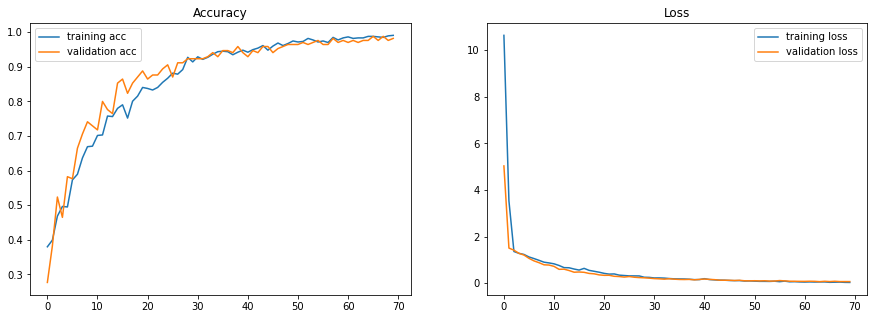

In [37]:
score = model.evaluate(X_test, y_test, batch_size=60, verbose=0)
print('Accuracy: {0:.0%}'.format(score[1]/1))
print("Loss: %.4f\n" % score[0])

# Plot accuracy and loss graphs
plt.figure(figsize = (15,5))
plt.subplot(1,2,1)
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label = 'training acc')
plt.plot(history.history['val_accuracy'], label = 'validation acc')
plt.legend()

plt.subplot(1,2,2)
plt.title('Loss')
plt.plot(history.history['loss'], label = 'training loss')
plt.plot(history.history['val_loss'], label = 'validation loss')
plt.legend()

                precision    recall  f1-score   support

          COPD       1.00      0.99      0.99        79
       Healthy       1.00      0.96      0.98        24
          URTI       0.94      0.94      0.94        16
Bronchiectasis       1.00      1.00      1.00        15
     Pneumoina       0.96      1.00      0.98        24
 Bronchiolitis       0.92      1.00      0.96        12

      accuracy                           0.98       170
     macro avg       0.97      0.98      0.97       170
  weighted avg       0.98      0.98      0.98       170



<AxesSubplot:xlabel='Predicted', ylabel='Actual'>

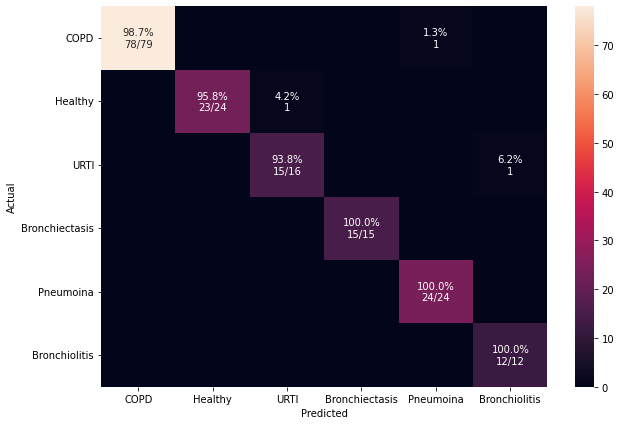

In [38]:
matrix_index = ["COPD", "Healthy", "URTI", "Bronchiectasis", "Pneumoina", "Bronchiolitis"]

preds = model.predict(X_test)
classpreds = np.argmax(preds, axis=1) # predicted classes 
y_testclass = np.argmax(y_test, axis=1) # true classes

cm = confusion_matrix(y_testclass, classpreds)
print(classification_report(y_testclass, classpreds, target_names=matrix_index))

# Get percentage value for each element of the matrix
cm_sum = np.sum(cm, axis=1, keepdims=True)
cm_perc = cm / cm_sum.astype(float) * 100
annot = np.empty_like(cm).astype(str)
nrows, ncols = cm.shape
for i in range(nrows):
    for j in range(ncols):
        c = cm[i, j]
        p = cm_perc[i, j]
        if i == j:
            s = cm_sum[i]
            annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
        elif c == 0:
            annot[i, j] = ''
        else:
            annot[i, j] = '%.1f%%\n%d' % (p, c)


# Display confusion matrix 
df_cm = pd.DataFrame(cm, index = matrix_index, columns = matrix_index)
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
fig, ax = plt.subplots(figsize=(10,7))
sn.heatmap(df_cm, annot=annot, fmt='')

In [ ]:
# pickle model for streamlit app 

In [42]:
# pickle serialization 

pickle_out = open("rsd_model.pkl", "wb")
pickle.dump(history, pickle_out) # history?  
pickle_out.close()

2022-05-06 22:20:12.641657: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ram://fce56f4d-0ae0-4567-abda-6a86ee224a7f/assets
